In [1]:
#!/usr/bin/env python
import os
import csv
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.rnn import BasicLSTMCell

import pickle
from typing import List

/home/danny/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Model Parameters

In [2]:
# from .decoding import get_words_from_chars
# from .config import Params, CONST
# from src.model import crnn_fn
# from src.data_handler import data_loader
# from src.data_handler import preprocess_image_for_prediction

# from src.config import Params, Alphabet, import_params_from_json

csv_files_train = "../data/my_handwriting/train.csv"
csv_files_eval = "../data/valid.csv"
output_model_dir = "./estimator"
output_graph_dir = "./graph"
if not os.path.isdir(output_model_dir):
    os.mkdir(output_model_dir)
if not os.path.isdir(output_graph_dir):
    os.mkdir(output_graph_dir)


n_epochs = 10
gpu = "" # help="GPU 0,1 or '' ", default=''

train_batch_size=64
eval_batch_size=64
# train_batch_size=10
# eval_batch_size=10
learning_rate=1e-3  # 1e-3 recommended
learning_decay_rate=0.95
learning_decay_steps=5000
evaluate_every_epoch=5
save_interval=5e3
input_shape=(129, 369) #iam shape
# input_shape=(117, 1669) # bentham shape1
# input_shape=(181, 1833) # bentham shape2
optimizer='adam'
digits_only=False
# alphabet=" !\"#&'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPQRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|"
alphabet="abcdefghijklmnopqrstuvwxyz"
alphabet_decoding='same'
alphabet_codes = list(range(len(alphabet)))
n_classes = len(alphabet)
csv_delimiter='\t'
keep_prob_dropout = 0.7


# Start of tensor graph

In [3]:
# needed for quickly making convolutional layers
def weightVar(shape, mean=0.0, stddev=0.02, name='weights'):
    init_w = tf.truncated_normal(shape=shape, mean=mean, stddev=stddev)
    return tf.Variable(init_w, name=name)


def biasVar(shape, value=0.0, name='bias'):
    init_b = tf.constant(value=value, shape=shape)
    return tf.Variable(init_b, name=name)


def conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME', name=None):
    return tf.nn.conv2d(input, filter, strides=strides, padding=padding, name=name)

In [4]:
#input_tensor = features['images']
input_tensor = tf.placeholder(tf.float32, [None, input_shape[0], input_shape[1], 1])
labels = tf.placeholder(tf.string, [None])
is_training = True

if input_tensor.shape[-1] == 1:
    input_channels = 1
elif input_tensor.shape[-1] == 3:
    input_channels = 3
else:
    raise NotImplementedError

# Deep cnn

In [5]:
with tf.variable_scope('deep_cnn'):
    # conv1 - maxPool2x2
    with tf.variable_scope('layer1'):
        W = weightVar([3, 3, input_channels, 64])
        b = biasVar([64])
        conv = conv2d(input_tensor, W, name='conv')
        out = tf.nn.bias_add(conv, b)
        conv1 = tf.nn.relu(out)
        pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], strides=[1, 2, 2, 1],
                               padding='SAME', name='pool')

    # conv2 - maxPool 2x2
    with tf.variable_scope('layer2'):
        W = weightVar([3, 3, 64, 128])
        b = biasVar([128])
        conv = conv2d(pool1, W)
        out = tf.nn.bias_add(conv, b)
        conv2 = tf.nn.relu(out)
        pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], strides=[1, 2, 2, 1],
                               padding='SAME', name='pool1')

    # conv3 - w/batch-norm (as source code, not paper)
    with tf.variable_scope('layer3'):
        W = weightVar([3, 3, 128, 256])
        b = biasVar([256])
        conv = conv2d(pool2, W)
        out = tf.nn.bias_add(conv, b)
        b_norm = tf.layers.batch_normalization(out, axis=-1,
                                               training=is_training, name='batch-norm')
        conv3 = tf.nn.relu(b_norm, name='ReLU')

    # conv4 - maxPool 2x1
    with tf.variable_scope('layer4'):
        W = weightVar([3, 3, 256, 256])
        b = biasVar([256])
        conv = conv2d(conv3, W)
        out = tf.nn.bias_add(conv, b)
        conv4 = tf.nn.relu(out)
        pool4 = tf.nn.max_pool(conv4, [1, 2, 2, 1], strides=[1, 2, 1, 1],
                               padding='SAME', name='pool4')

    # conv5 - w/batch-norm
    with tf.variable_scope('layer5'):
        W = weightVar([3, 3, 256, 512])
        b = biasVar([512])
        conv = conv2d(pool4, W)
        out = tf.nn.bias_add(conv, b)
        b_norm = tf.layers.batch_normalization(out, axis=-1,
                                               training=is_training, name='batch-norm')
        conv5 = tf.nn.relu(b_norm)

    # conv6 - maxPool 2x1 (as source code, not paper)
    with tf.variable_scope('layer6'):
        W = weightVar([3, 3, 512, 512])
        b = biasVar([512])
        conv = conv2d(conv5, W)
        out = tf.nn.bias_add(conv, b)
        conv6 = tf.nn.relu(out)
        pool6 = tf.nn.max_pool(conv6, [1, 2, 2, 1], strides=[1, 2, 1, 1],
                               padding='SAME', name='pool6')

    # conv 7 - w/batch-norm (as source code, not paper)
    with tf.variable_scope('layer7'):
        W = weightVar([2, 2, 512, 512])
        b = biasVar([512])
        conv = conv2d(pool6, W, padding='VALID')
        out = tf.nn.bias_add(conv, b)
        b_norm = tf.layers.batch_normalization(out, axis=-1,
                                               training=is_training, name='batch-norm')
        conv7 = tf.nn.relu(b_norm)

    # reshape output
    with tf.variable_scope('Reshaping_cnn'):
        shape = conv7.get_shape().as_list()  # [batch, height, width, features]
        shape_tens = tf.shape(conv7)
        transposed = tf.transpose(conv7, perm=[0, 2, 1, 3],
                                  name='transposed')  # [batch, width, height, features]
        conv_out = tf.reshape(transposed, [shape_tens[0], -1, shape[1] * shape[3]],
                                   name='reshaped')  # [batch, width, height x features]

# Bidirectional lstm

In [6]:
# logprob, raw_pred = deep_bidirectional_lstm(conv, params=parameters, summaries=False)

# def deep_bidirectional_lstm(inputs: tf.Tensor, params: Params, summaries: bool=True) -> tf.Tensor:
# Prepare data shape to match `bidirectional_rnn` function requirements
# Current data input shape: (batch_size, n_steps, n_input) "(batch, time, height)"

list_n_hidden = [256, 256]

with tf.name_scope('deep_bidirectional_lstm'):
    # Forward direction cells
    fw_cell_list = [BasicLSTMCell(nh, forget_bias=1.0) for nh in list_n_hidden]
    # Backward direction cells
    bw_cell_list = [BasicLSTMCell(nh, forget_bias=1.0) for nh in list_n_hidden]

    lstm_net, _, _ = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(fw_cell_list,
                                                                    bw_cell_list,
                                                                    conv_out, # THE INPUT
                                                                    dtype=tf.float32
                                                                    )

    # Dropout layer
    lstm_net = tf.nn.dropout(lstm_net, keep_prob=keep_prob_dropout)

    with tf.variable_scope('Reshaping_rnn'):
        shape = lstm_net.get_shape().as_list()  # [batch, width, 2*n_hidden]
        rnn_reshaped = tf.reshape(lstm_net, [-1, shape[-1]])  # [batch x width, 2*n_hidden]

    with tf.variable_scope('fully_connected'):
        W = weightVar([list_n_hidden[-1]*2, n_classes])
        b = biasVar([n_classes])
        fc_out = tf.nn.bias_add(tf.matmul(rnn_reshaped, W), b)

    shape_tens = tf.shape(lstm_net)
    lstm_out = tf.reshape(fc_out, [shape_tens[0], -1, n_classes], name='reshape_out')  # [batch, width, n_classes]

    raw_pred = tf.argmax(tf.nn.softmax(lstm_out), axis=2, name='raw_prediction')

    # Swap batch and time axis
    lstm_out = tf.transpose(lstm_out, [1, 0, 2], name='transpose_time_major')  # [width(time), batch, n_classes]
    

# CTC loss

In [7]:
# Set up for loss and training

# Compute seq_len from image width
n_pools = 2*2  # 2x2 pooling in dimension W on layer 1 and 2
seq_len_inputs = tf.divide([input_shape[1]]*train_batch_size, n_pools,
                           name='seq_len_input_op') - 1

predictions_dict = {'prob': lstm_out,
                    'raw_predictions': raw_pred,
                    }


# Get keys (letters) and values (integer stand ins for letters)
# Alphabet and codes
keys = [c for c in alphabet] # the letters themselves
values = alphabet_codes # integer representations


# Create non-string labels from the keys and values above
# Convert string label to code label
with tf.name_scope('str2code_conversion'):
    table_str2int = tf.contrib.lookup.HashTable(tf.contrib.lookup.KeyValueTensorInitializer(keys, values), -1)
    splited = tf.string_split(labels, delimiter='')  # TODO change string split to utf8 split in next tf version
    codes = table_str2int.lookup(splited.values)
    sparse_code_target = tf.SparseTensor(splited.indices, codes, splited.dense_shape)

seq_lengths_labels = tf.bincount(tf.cast(sparse_code_target.indices[:, 0], tf.int32),
                                 minlength=tf.shape(predictions_dict['prob'])[1])


# Use ctc loss on probabilities from lstm output
# Loss
# ----
# >>> Cannot have longer labels than predictions -> error
with tf.control_dependencies([tf.less_equal(sparse_code_target.dense_shape[1], tf.reduce_max(tf.cast(seq_len_inputs, tf.int64)))]):
    loss_ctc = tf.nn.ctc_loss(labels=sparse_code_target,
                              inputs=predictions_dict['prob'],
                              sequence_length=tf.cast(seq_len_inputs, tf.int32),
                              preprocess_collapse_repeated=False,
                              ctc_merge_repeated=True,
                              ignore_longer_outputs_than_inputs=True,  # returns zero gradient in case it happens -> ema loss = NaN
                              time_major=True)
    loss_ctc = tf.reduce_mean(loss_ctc)
    loss_ctc = tf.Print(loss_ctc, [loss_ctc], message='* Loss : ')

# CTC decoding

In [8]:
def get_words_from_chars(characters_list: List[str], sequence_lengths: List[int], name='chars_conversion'):
    with tf.name_scope(name=name):
        def join_charcaters_fn(coords):
            return tf.reduce_join(characters_list[coords[0]:coords[1]])

        def coords_several_sequences():
            end_coords = tf.cumsum(sequence_lengths)
            start_coords = tf.concat([[0], end_coords[:-1]], axis=0)
            coords = tf.stack([start_coords, end_coords], axis=1)
            coords = tf.cast(coords, dtype=tf.int32)
            return tf.map_fn(join_charcaters_fn, coords, dtype=tf.string)

        def coords_single_sequence():
            return tf.reduce_join(characters_list, keep_dims=True)

        words = tf.cond(tf.shape(sequence_lengths)[0] > 1,
                        true_fn=lambda: coords_several_sequences(),
                        false_fn=lambda: coords_single_sequence())

        return words

In [9]:
with tf.name_scope('code2str_conversion'):
    keys = tf.cast(alphabet_codes, tf.int64)
    values = [c for c in alphabet]

    table_int2str = tf.contrib.lookup.HashTable(tf.contrib.lookup.KeyValueTensorInitializer(keys, values), '?')

    sparse_code_pred, log_probability = tf.nn.ctc_beam_search_decoder(predictions_dict['prob'],
                                                                      sequence_length=tf.cast(seq_len_inputs, tf.int32),
                                                                      merge_repeated=False,
                                                                      beam_width=100,
                                                                      top_paths=2)
    # Score
    predictions_dict['score'] = tf.subtract(log_probability[:, 0], log_probability[:, 1])
    # around 10.0 -> seems pretty sure, less than 5.0 bit unsure, some errors/challenging images
    sparse_code_pred = sparse_code_pred[0]

    sequence_lengths_pred = tf.bincount(tf.cast(sparse_code_pred.indices[:, 0], tf.int32),
                                        minlength=tf.shape(predictions_dict['prob'])[1])

    pred_chars = table_int2str.lookup(sparse_code_pred)
    predictions_dict['words'] = get_words_from_chars(pred_chars.values, sequence_lengths=sequence_lengths_pred)

    tf.summary.text('predicted_words', predictions_dict['words'][:10])

In [10]:
with tf.name_scope('evaluation'):
    CER = tf.metrics.mean(tf.edit_distance(sparse_code_pred, tf.cast(sparse_code_target, dtype=tf.int64)), name='CER')
    CER = tf.reduce_mean(tf.edit_distance(sparse_code_pred, tf.cast(sparse_code_target, dtype=tf.int64)), name='CER')

    # Convert label codes to decoding alphabet to compare predicted and groundtrouth words
    target_chars = table_int2str.lookup(tf.cast(sparse_code_target, tf.int64))
    target_words = get_words_from_chars(target_chars.values, seq_lengths_labels)
    accuracy = tf.metrics.accuracy(target_words, predictions_dict['words'], name='accuracy')

    eval_metric_ops = {
                       'eval/accuracy': accuracy,
                       'eval/CER': CER,
                       }
    CER = tf.Print(CER, [CER], message='-- CER : ')
    accuracy = tf.Print(accuracy, [accuracy], message='-- Accuracy : ')


# Set up optimizer

In [11]:
# Create the learning rate as well as a moving average
global_step = tf.train.get_or_create_global_step()
# # Create an ExponentialMovingAverage object
ema = tf.train.ExponentialMovingAverage(decay=0.99, num_updates=global_step, zero_debias=True)
# Create the shadow variables, and add op to maintain moving averages
maintain_averages_op = ema.apply([loss_ctc])
loss_ema = ema.average(loss_ctc)

# Train op
# --------
learning_rate = tf.train.exponential_decay(learning_rate, global_step,
                                           learning_decay_steps, learning_decay_rate,
                                           staircase=True)

# Set up optimizer
if optimizer == 'ada':
    optimizer = tf.train.AdadeltaOptimizer(learning_rate)
elif optimizer == 'adam':
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
elif optimizer == 'rms':
    optimizer = tf.train.RMSPropOptimizer(learning_rate)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
opt_op = optimizer.minimize(loss_ctc, global_step=global_step)
with tf.control_dependencies(update_ops + [opt_op]):
    train_op = tf.group(maintain_averages_op)

# Import data

In [12]:
# from PIL import Image

# # modify images
# mydir = "../data/my_handwriting/orig_pics/"
# mydir2 = "../data/my_handwriting/"
# files = os.listdir(mydir)
# imgs = [Image.open(mydir+f) for f in files]

# for i in range(len(imgs)):
#     im = imgs[i].copy()
#     npim = np.asarray(im)
#     if npim.shape[0] > input_shape[0] or npim.shape[1] > input_shape[1]:
#         im.thumbnail((input_shape[1], input_shape[0]))
#     imgs[i] = im.convert("L")
#     imgs[i].save(mydir2+files[i])

In [13]:
# get the details to make all images the same size

with open(csv_files_train, "r") as f:
    f_lines = f.read().splitlines()
    filenames = [l.split(",")[0] for l in f_lines]
    label_list = [l.split(",")[1] for l in f_lines]

datasize = len(label_list)
filenames = tf.constant(filenames)
label_list = tf.constant(label_list)
    
def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=1)
    image_resized = tf.image.resize_image_with_crop_or_pad(image_decoded,
                                                           input_shape[0],
                                                           input_shape[1])
    return image_resized, label
    
dataset = tf.data.Dataset.from_tensor_slices((filenames, label_list))
dataset = dataset.map(_parse_function)
dataset = dataset.batch(train_batch_size)
iterator = dataset.make_initializable_iterator()
next_batch = iterator.get_next()

# Try getting actual predictions

In [14]:
saver = tf.train.Saver()

with tf.Session() as sess:
    start_time = time.time()
    sess.run(tf.local_variables_initializer())
    sess.run(tf.tables_initializer())
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, output_model_dir+"/model.ckpt")
    
    print("Starting epoch")
    sess.run(iterator.initializer)
    input_tensor_b, labels_b = sess.run(next_batch)

    try:
        cer, acc, loss, preddict, scp, pc = sess.run([CER, accuracy, loss_ctc, predictions_dict,
                                                      sparse_code_pred, pred_chars],
                     feed_dict={input_tensor: input_tensor_b, labels: labels_b})
#         print('batch, CER: {1}, accuracy: {2}, loss: {3}'.format(cer, acc, loss))
    except:
        print("Error")

    print('Total time: {0} seconds'.format(time.time() - start_time))

INFO:tensorflow:Restoring parameters from ./estimator/model.ckpt
Starting epoch
Total time: 49.207770347595215 seconds


In [15]:
import matplotlib.pyplot as plt
from PIL import Image

imfold = "/home/danny/Repos/text_recognition/data/my_handwriting/"

## "to"

to


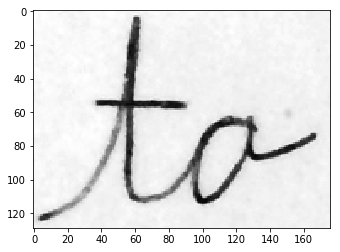

to


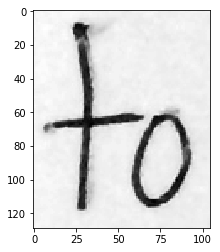

to


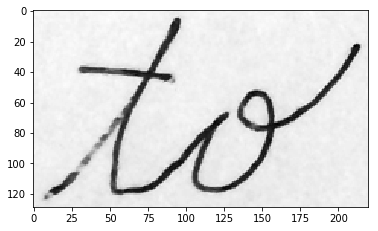

to


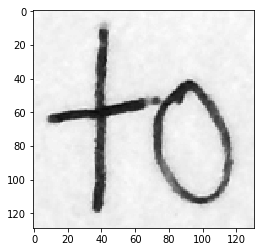

In [16]:
word = "to"
j=2
for i in range(4):
    print(str(preddict["words"][4*j+i], "UTF-8"))
    im = Image.open(imfold + word + str(i+1) + ".png")
    plt.imshow(np.asarray(im), cmap="gray")
    plt.show()

## "the"

thee


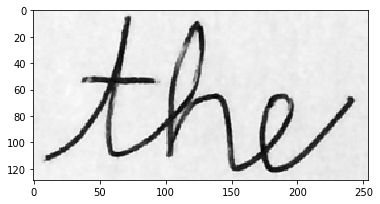

the


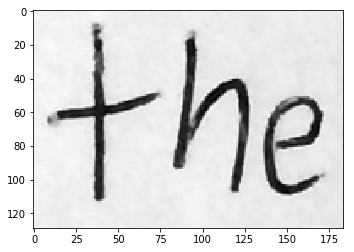

the


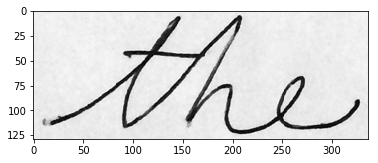

the


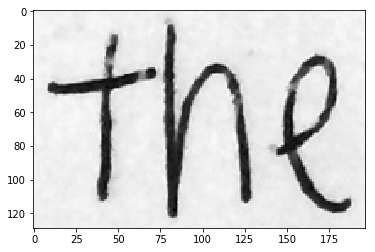

In [17]:
word = "the"
j=1
for i in range(4):
    print(str(preddict["words"][4*j+i], "UTF-8"))
    im = Image.open(imfold + word + str(i+1) + ".png")
    plt.imshow(np.asarray(im), cmap="gray")
    plt.show()

## "composition"

composition


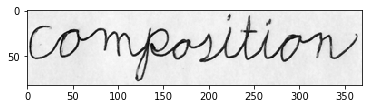

composition


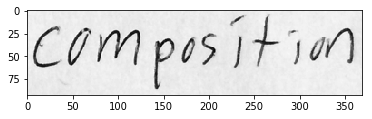

compoiliow


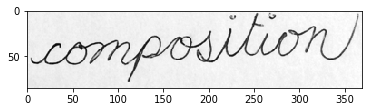

composition


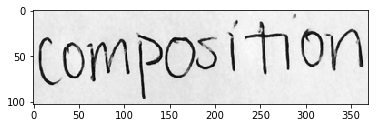

In [18]:
word = "composition"
j=0
for i in range(4):
    print(str(preddict["words"][4*j+i], "UTF-8"))
    im = Image.open(imfold + word + str(i+1) + ".png")
    plt.imshow(np.asarray(im), cmap="gray")
    plt.show()

## "words"

wvouds


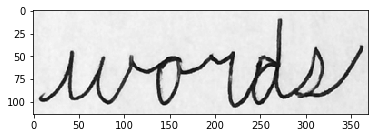

wonds


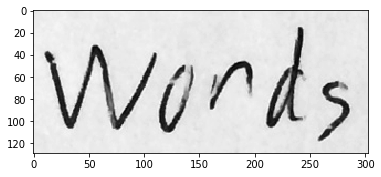

wold


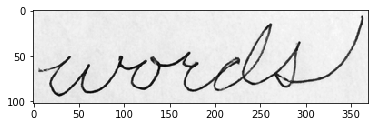

words


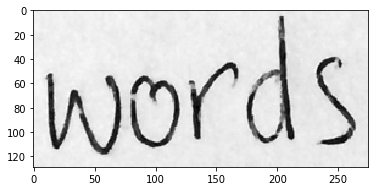

In [19]:
word = "words"
j=3
for i in range(4):
    print(str(preddict["words"][4*j+i], "UTF-8"))
    im = Image.open(imfold + word + str(i+1) + ".png")
    plt.imshow(np.asarray(im), cmap="gray")
    plt.show()